In [1]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Model
from keras.optimizers import Adam, RMSprop,  Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.applications import VGG19
from tensorflow.keras import models, layers
from tensorflow.keras.saving import save_model
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

from utils.utils import plot_line, plot_metrics, plot_confusion_matrix

In [2]:
data_dir = '..\dataset'
classes = ('REAL', 'FAKE')

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="training",
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

val_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="validation",
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

test_images = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical')

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [14]:
model_out = base_model.output 
model_out = layers.GlobalAveragePooling2D()(model_out)

fc1 = layers.Dense(1024, activation='relu')(model_out)
fc2 = layers.Dense(512, activation='relu')(fc1)
fc3 = layers.Dense(256, activation='relu')(fc2)

output = layers.Dense(2, activation='softmax')(fc3)

base_model.trainable = True

fine_tune_at = -3

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=output)


In [15]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
1011/2500 [===========>..................] - ETA: 35:10 - loss: 0.4737 - accuracy: 0.7779

In [13]:
save_model(model, '../models/VGG19')
loaded_model = load_model('../models/VGG19')

INFO:tensorflow:Assets written to: ../models/VGG19\assets


INFO:tensorflow:Assets written to: ../models/VGG19\assets


In [14]:
hist_df = pd.DataFrame(history.history)
hist_df.columns = ['train_loss', 'train_acc', 'validation_loss', 'validation_acc']
hist_df.index = hist_df.index + 1
hist_df.to_csv('../history/VGG19.csv')

In [15]:
loss, accuracy = loaded_model.evaluate(test_images)
print(f"Loss : {loss}")
print(f"Accuracy : {accuracy}")

625/625 [==============================] - 58s 92ms/step - loss: 0.3425 - accuracy: 0.8585
Loss : 0.34248149394989014
Accuracy : 0.8585000038146973


In [16]:
y_true = []
y_pred = []
for batch_id in range(len(test_images)):
    batch_images = test_images[batch_id][0]
    batch_labels = test_images[batch_id][1]
    batch_predictions = loaded_model.predict(batch_images)
    batch_predictions = (batch_predictions > 0.5).astype(int)
    y_true.extend(batch_labels)
    y_pred.extend(batch_predictions)

1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 101ms/step


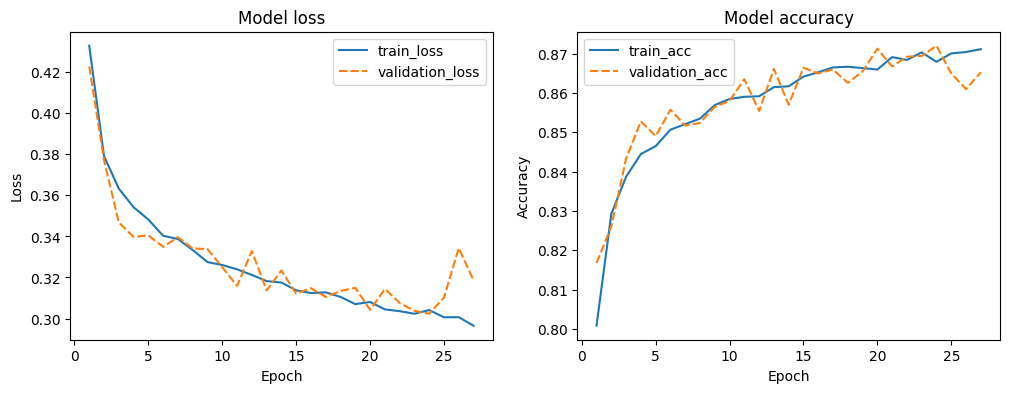

In [17]:
plot_line(hist_df)

In [27]:
y_pred2 = [np.argmax(i) for i in y_pred]
y_true2 = [np.argmax(i) for i in y_true]

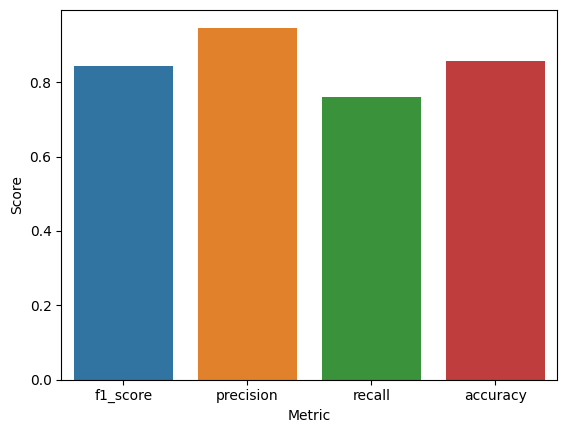

In [28]:
plot_metrics(y_true2, y_pred2)

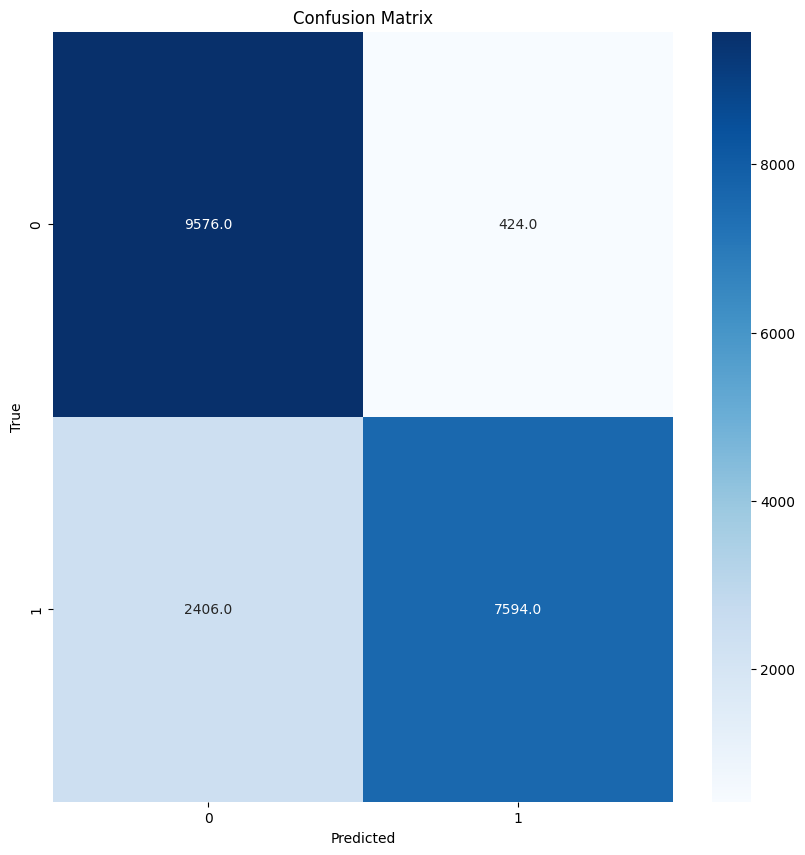

In [29]:
plot_confusion_matrix(y_true2, y_pred2)

In [36]:
base_model = VGG19(weights="imagenet", include_top=False)
model_out = base_model.output 
model_out = layers.GlobalAveragePooling2D()(model_out)
output = layers.Dense(2, activation='softmax')(model_out)
model2 = Model(inputs=base_model.input, outputs=output)
base_model.trainable = True

fine_tune_at = -3

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [39]:
optimizer = Nadam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [40]:
history2 = model2.fit(train_images, epochs=100, validation_data=val_images, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 618s 247ms/step - loss: 0.4450 - accuracy: 0.7957 - val_loss: 0.3987 - val_accuracy: 0.8148
Epoch 2/100
2500/2500 [==============================] - 4026s 2s/step - loss: 0.3806 - accuracy: 0.8283 - val_loss: 0.3644 - val_accuracy: 0.8388
Epoch 3/100
2500/2500 [==============================] - 913s 365ms/step - loss: 0.3656 - accuracy: 0.8368 - val_loss: 0.3575 - val_accuracy: 0.8411
Epoch 4/100
2500/2500 [==============================] - 671s 269ms/step - loss: 0.3592 - accuracy: 0.8416 - val_loss: 0.3578 - val_accuracy: 0.8412
Epoch 5/100
2500/2500 [==============================] - 552s 221ms/step - loss: 0.3506 - accuracy: 0.8453 - val_loss: 0.3422 - val_accuracy: 0.8505
Epoch 6/100
2500/2500 [==============================] - 564s 226ms/step - loss: 0.3504 - accuracy: 0.8453 - val_loss: 0.3433 - val_accuracy: 0.8507
Epoch 7/100
2500/2500 [==============================] - 552s 221ms/step - loss: 0.3439 - accuracy: 0.8504 -